## Water Potability Prediction Model
#### Individual Assignment Tabea Herbst

In [37]:
import pandas as pd
import seaborn as sns
from sklearn.model_selection import StratifiedKFold
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import RandomOverSampler
import pickle


In [38]:
data = pd.read_csv("water_potability.csv")

In [39]:
data.head()

ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
0       NaN  204.890455  20791.318981     7.300212  368.516441    564.308654   
1  3.716080  129.422921  18630.057858     6.635246         NaN    592.885359   
2  8.099124  224.236259  19909.541732     9.275884         NaN    418.606213   
3  8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4  9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
0       10.379783        86.990970   2.963135           0  
1       15.180013        56.329076   4.500656           0  
2       16.868637        66.420093   3.055934           0  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0

In [40]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [41]:
# There are quite a few rows with Null values but as the dataset is big enough, I will simply delete these rows during EDA
# All datatypes are correct

In [42]:
data.describe()

ph     Hardness        Solids  Chloramines      Sulfate  \
count  2785.000000  3276.000000   3276.000000  3276.000000  2495.000000   
mean      7.080795   196.369496  22014.092526     7.122277   333.775777   
std       1.594320    32.879761   8768.570828     1.583085    41.416840   
min       0.000000    47.432000    320.942611     0.352000   129.000000   
25%       6.093092   176.850538  15666.690297     6.127421   307.699498   
50%       7.036752   196.967627  20927.833607     7.130299   333.073546   
75%       8.062066   216.667456  27332.762127     8.114887   359.950170   
max      14.000000   323.124000  61227.196008    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   3276.000000     3276.000000      3114.000000  3276.000000  3276.000000  
mean     426.205111       14.284970        66.396293     3.966786     0.390110  
std       80.824064        3.308162        16.175008     0.780382     0.487849  
min      181.483754        2.200000         0.738000     1.450000     0.000000  
25%      365.734414       12.065801        55.844536     3.439711     0.000000  
50%      421.884968       14.218338        66.622485     3.955028     0.000000  
75%      481.792304       16.557652        77.337473     4.500320     1.000000  
max      753.342620       28.300000       124.000000     6.739000     1.000000

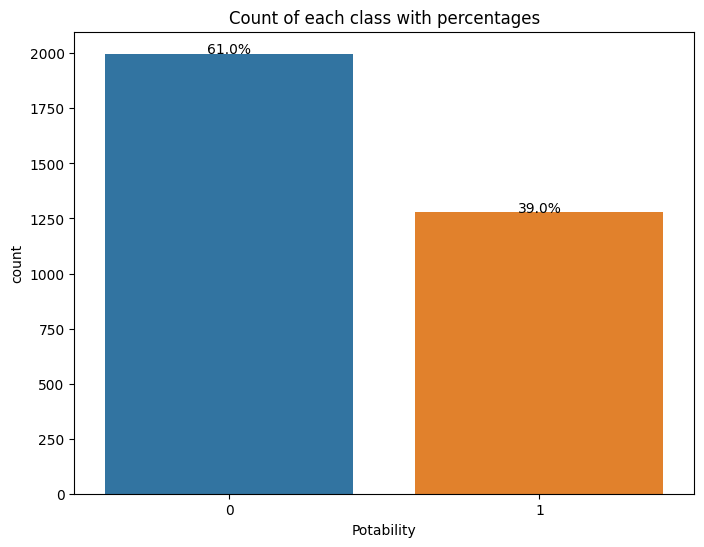

In [43]:
plt.figure(figsize=(8, 6))
ax = sns.countplot(x='Potability', data=data)

total = len(data['Potability'])
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height() / total)
    ax.text(p.get_x() + p.get_width() / 2, p.get_height(), percentage, ha='center')

# Show the plot
plt.title('Count of each class with percentages')
plt.show()

In [44]:
#Dataset is slightly unbalanced so I will balance it befoer training the model

In [45]:
data.duplicated().sum()

0

In [46]:
#no duplicate rows

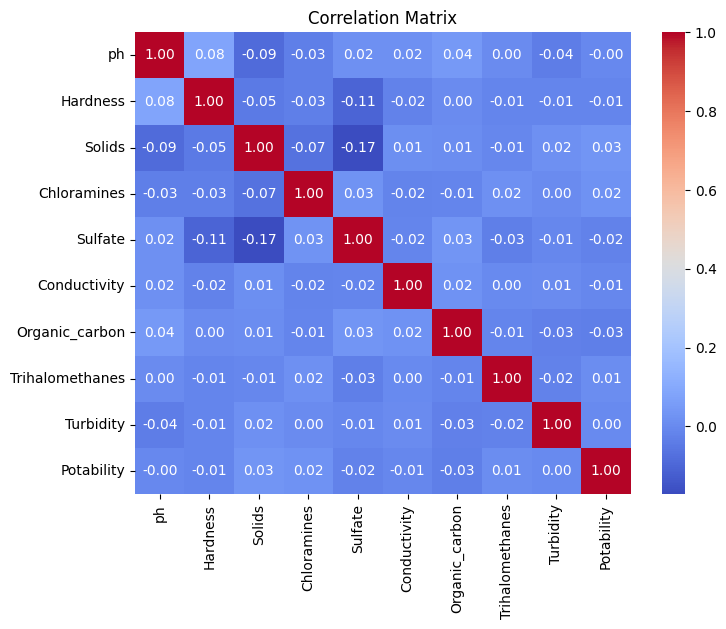

In [47]:
correlation_matrix = data.corr()

# Create a heatmap using seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

In [48]:
# Very low correlation with target variable, a robust model may be challenging to build

In [49]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


In [50]:
batch1 = ['ph', 'Chloramines', 'Organic_carbon', 'Turbidity']
batch2 = ['Hardness', 'Sulfate', 'Conductivity','Trihalomethanes']
batch3 = ['Solids']

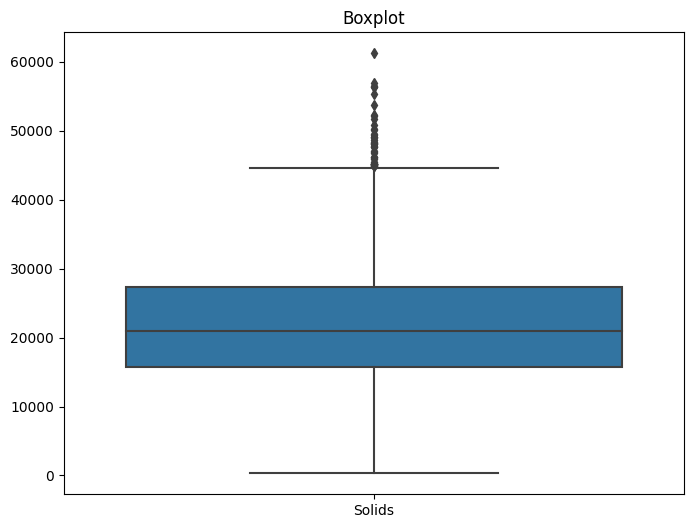

In [51]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=data[batch3])
plt.title("Boxplot")
plt.show()

In [52]:
# No severe extreme values

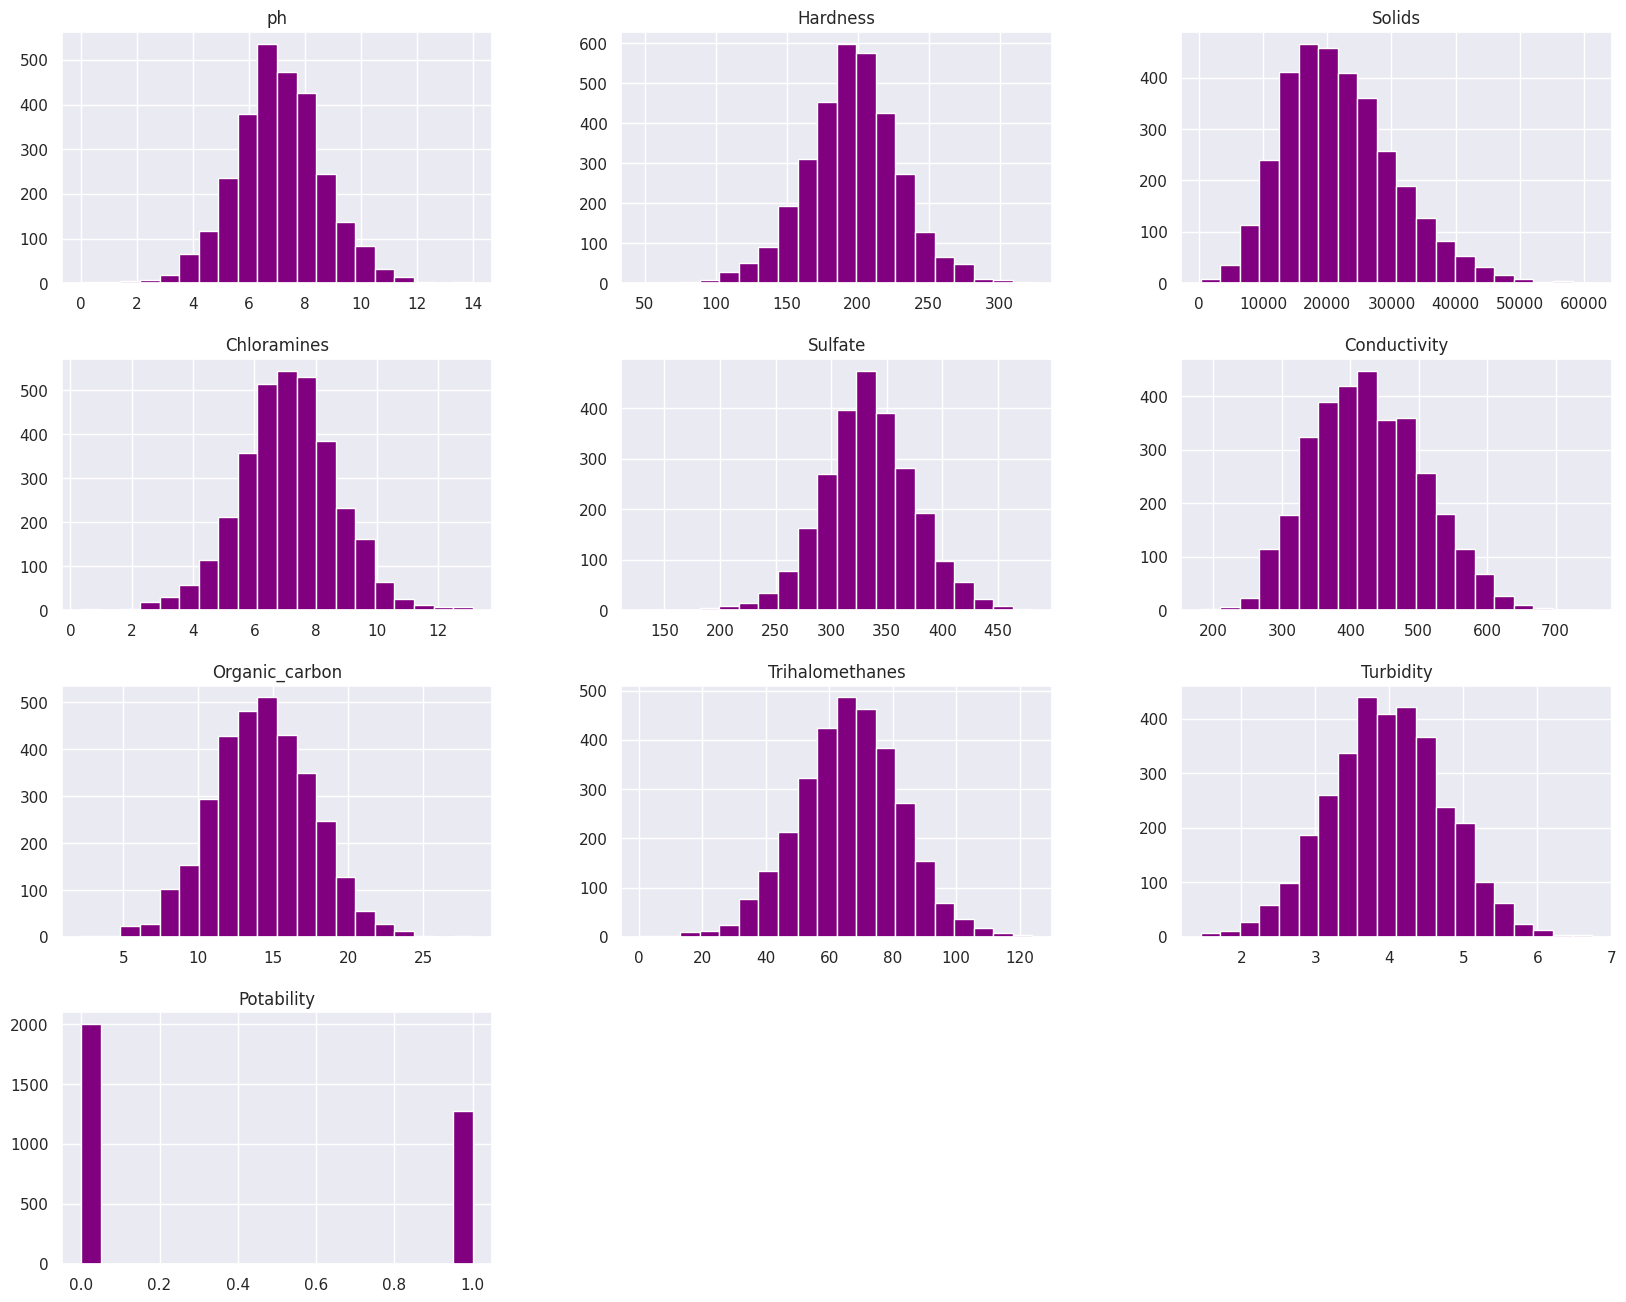

In [53]:
# Plot histograms
sns.set(rc={'figure.figsize': (20, 16)})

# Specify the number of bins for accuracy
num_bins = 20
data.hist(bins=num_bins, color='purple')

plt.xlabel('Variable to Plot')
plt.ylabel('Frequency')
plt.title('Histogram with Specified Number of Bins')
plt.show()

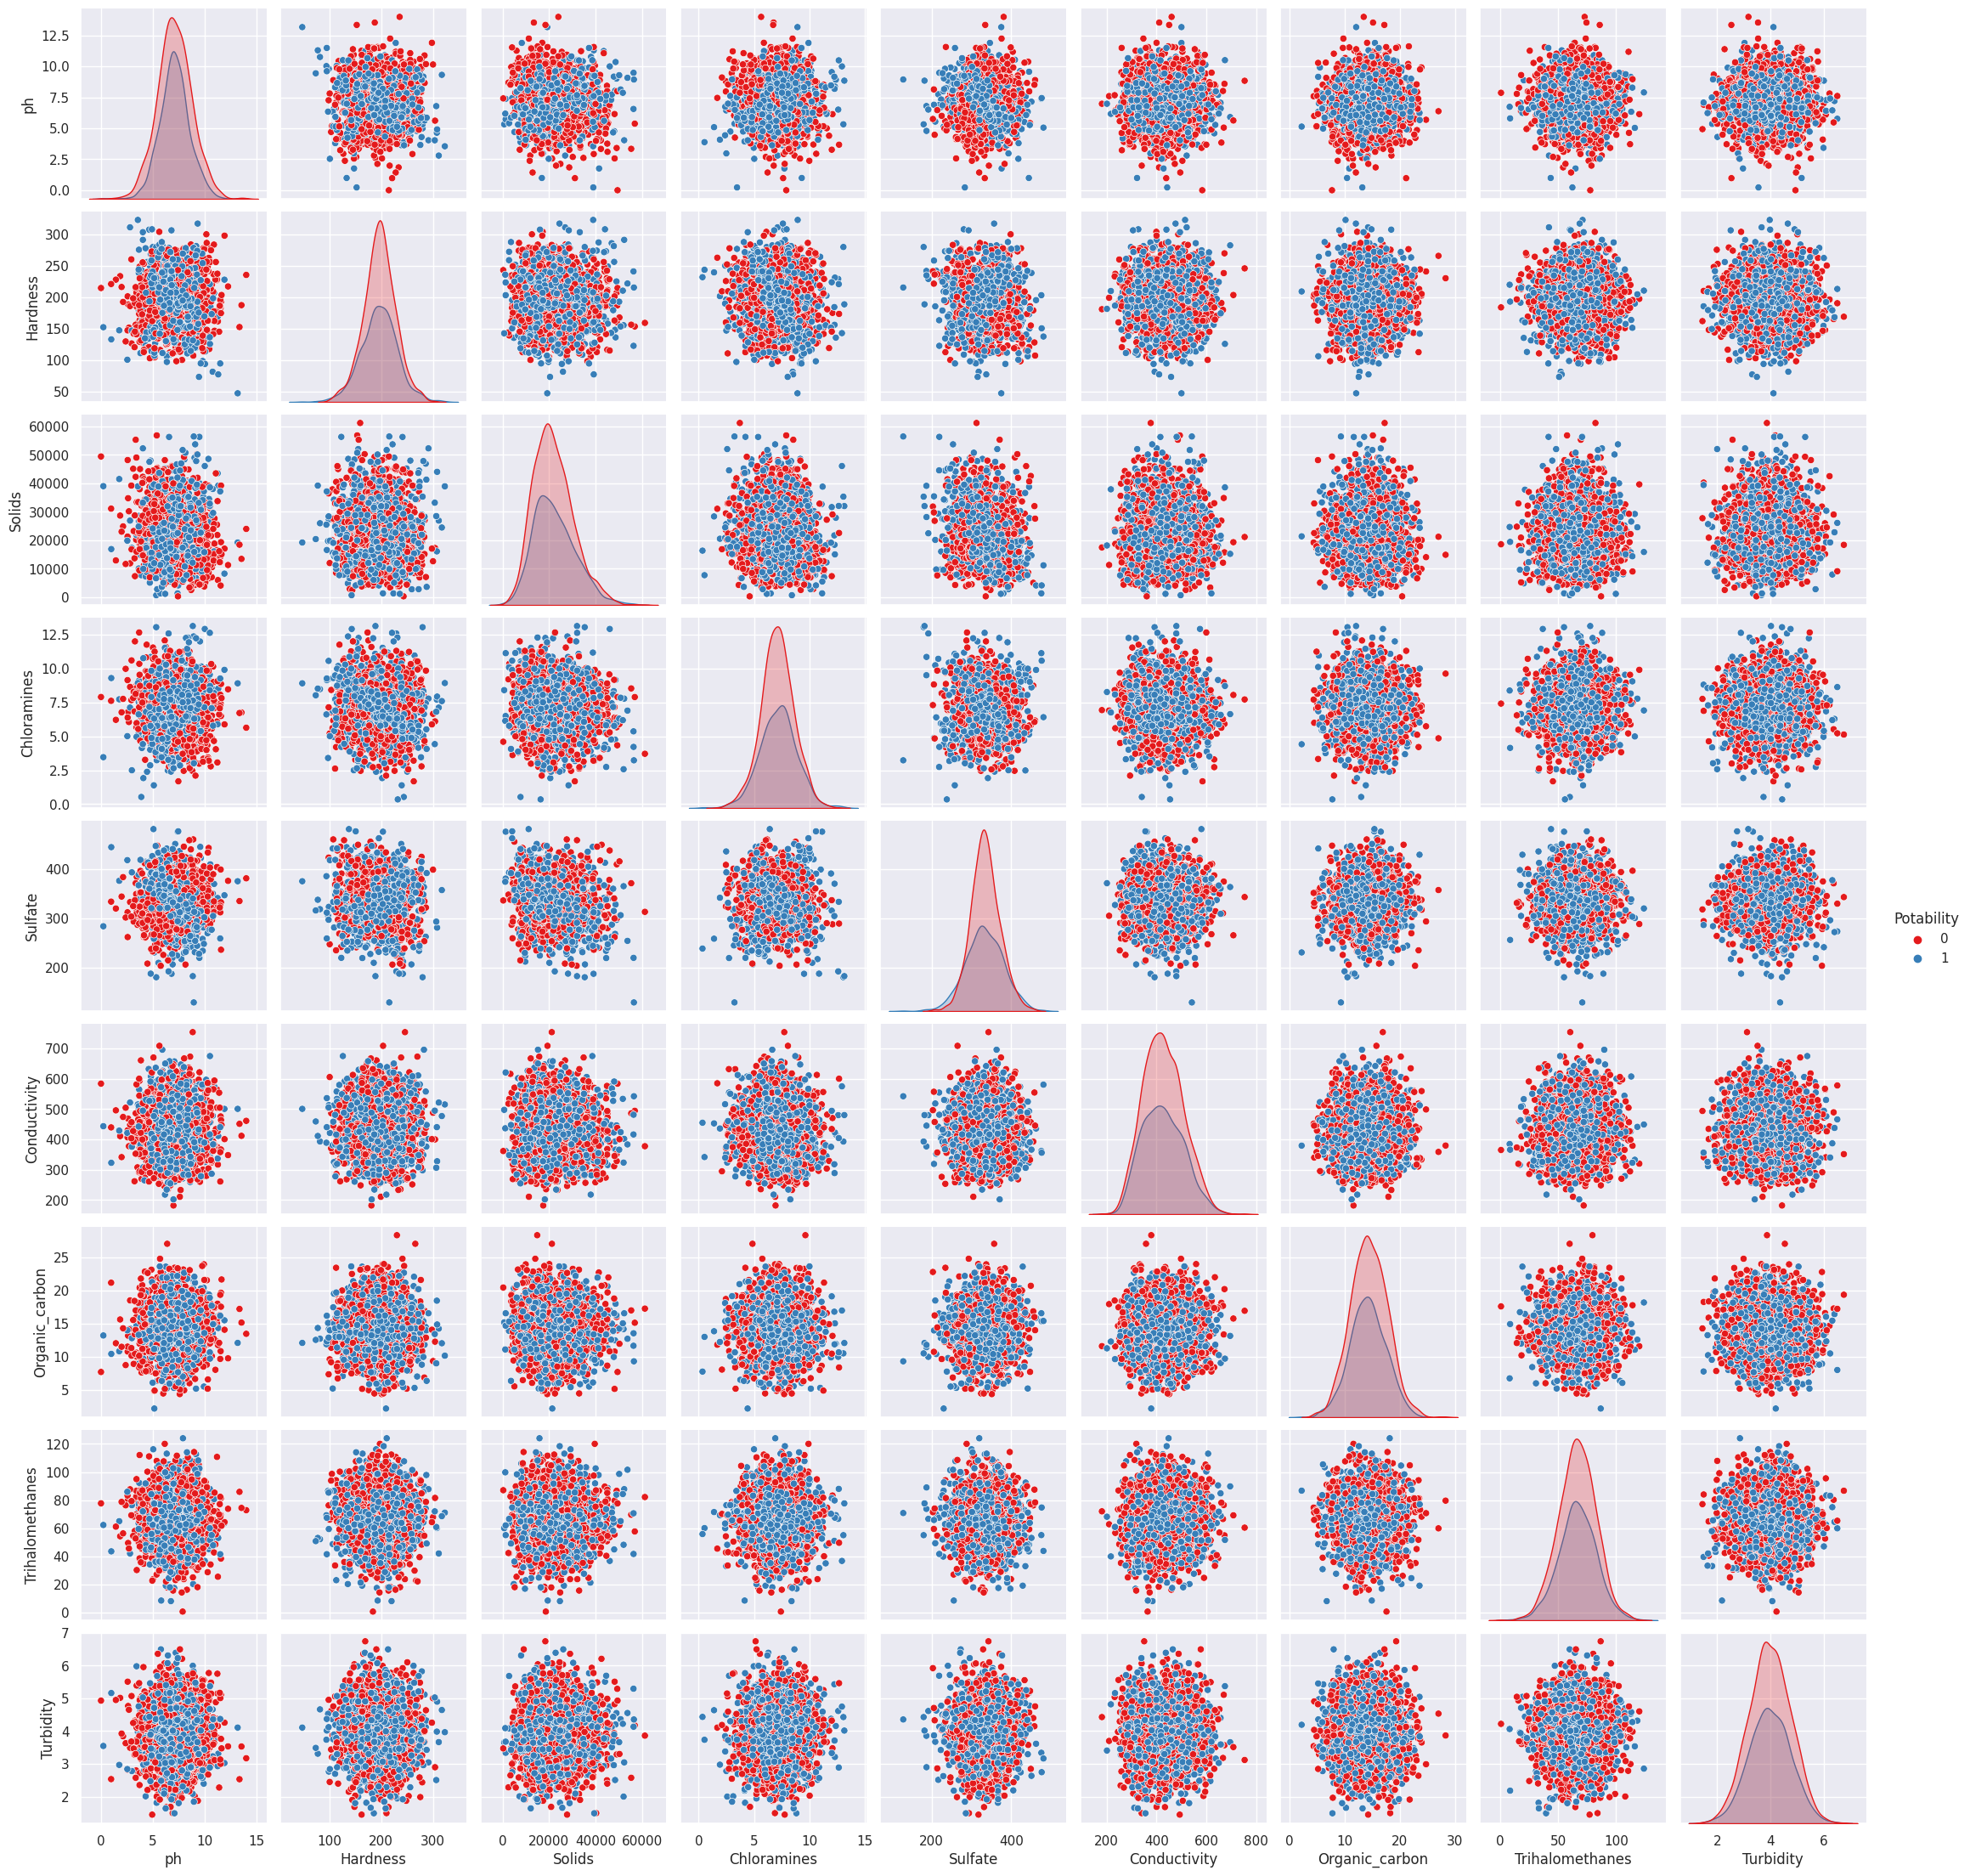

In [54]:
sns.pairplot(data,hue='Potability',palette='Set1')

### Preprocessing

In [55]:
# delete all rows with Null values
data.dropna(inplace=True)

In [56]:
data.head()

ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
3   8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4   9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   
5   5.584087  188.313324  28748.687739     7.544869  326.678363    280.467916   
6  10.223862  248.071735  28749.716544     7.513408  393.663396    283.651634   
7   8.635849  203.361523  13672.091764     4.563009  303.309771    474.607645   

   Organic_carbon  Trihalomethanes  Turbidity  Potability  
3       18.436524       100.341674   4.628771           0  
4       11.558279        31.997993   4.075075           0  
5        8.399735        54.917862   2.559708           0  
6       13.789695        84.603556   2.672989           0  
7       12.363817        62.798309   4.401425           0

In [57]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2011 entries, 3 to 3271
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2011 non-null   float64
 1   Hardness         2011 non-null   float64
 2   Solids           2011 non-null   float64
 3   Chloramines      2011 non-null   float64
 4   Sulfate          2011 non-null   float64
 5   Conductivity     2011 non-null   float64
 6   Organic_carbon   2011 non-null   float64
 7   Trihalomethanes  2011 non-null   float64
 8   Turbidity        2011 non-null   float64
 9   Potability       2011 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 172.8 KB


In [58]:
data.describe()

ph     Hardness        Solids  Chloramines      Sulfate  \
count  2011.000000  2011.000000   2011.000000  2011.000000  2011.000000   
mean      7.085990   195.968072  21917.441374     7.134338   333.224672   
std       1.573337    32.635085   8642.239815     1.584820    41.205172   
min       0.227499    73.492234    320.942611     1.390871   129.000000   
25%       6.089723   176.744938  15615.665390     6.138895   307.632511   
50%       7.027297   197.191839  20933.512750     7.143907   332.232177   
75%       8.052969   216.441070  27182.587067     8.109726   359.330555   
max      14.000000   317.338124  56488.672413    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity   Potability  
count   2011.000000     2011.000000      2011.000000  2011.000000  2011.000000  
mean     426.526409       14.357709        66.400859     3.969729     0.403282  
std       80.712572        3.324959        16.077109     0.780346     0.490678  
min      201.619737        2.200000         8.577013     1.450000     0.000000  
25%      366.680307       12.124105        55.952664     3.442915     0.000000  
50%      423.455906       14.322019        66.542198     3.968177     0.000000  
75%      482.373169       16.683049        77.291925     4.514175     1.000000  
max      753.342620       27.006707       124.000000     6.494749     1.000000

In [59]:
# Feature engineer variables with highest feature importance for a more accurate model
data["pHxSulfate"] = data["ph"] * data["Sulfate"]

In [60]:
data["SulfatexChloramines"] = data["Sulfate"] * data["Chloramines"]

In [61]:
data.head()

ph    Hardness        Solids  Chloramines     Sulfate  Conductivity  \
3   8.316766  214.373394  22018.417441     8.059332  356.886136    363.266516   
4   9.092223  181.101509  17978.986339     6.546600  310.135738    398.410813   
5   5.584087  188.313324  28748.687739     7.544869  326.678363    280.467916   
6  10.223862  248.071735  28749.716544     7.513408  393.663396    283.651634   
7   8.635849  203.361523  13672.091764     4.563009  303.309771    474.607645   

   Organic_carbon  Trihalomethanes  Turbidity  Potability   pHxSulfate  \
3       18.436524       100.341674   4.628771           0  2968.138437   
4       11.558279        31.997993   4.075075           0  2819.823427   
5        8.399735        54.917862   2.559708           0  1824.200281   
6       13.789695        84.603556   2.672989           0  4024.760295   
7       12.363817        62.798309   4.401425           0  2619.337299   

   SulfatexChloramines  
3          2876.263988  
4          2030.334611  
5          2464.745384  
6          2957.753889  
7          1384.005120

In [62]:
data.describe()

ph     Hardness        Solids  Chloramines      Sulfate  \
count  2011.000000  2011.000000   2011.000000  2011.000000  2011.000000   
mean      7.085990   195.968072  21917.441374     7.134338   333.224672   
std       1.573337    32.635085   8642.239815     1.584820    41.205172   
min       0.227499    73.492234    320.942611     1.390871   129.000000   
25%       6.089723   176.744938  15615.665390     6.138895   307.632511   
50%       7.027297   197.191839  20933.512750     7.143907   332.232177   
75%       8.052969   216.441070  27182.587067     8.109726   359.330555   
max      14.000000   317.338124  56488.672413    13.127000   481.030642   

       Conductivity  Organic_carbon  Trihalomethanes    Turbidity  \
count   2011.000000     2011.000000      2011.000000  2011.000000   
mean     426.526409       14.357709        66.400859     3.969729   
std       80.712572        3.324959        16.077109     0.780346   
min      201.619737        2.200000         8.577013     1.450000   
25%      366.680307       12.124105        55.952664     3.442915   
50%      423.455906       14.322019        66.542198     3.968177   
75%      482.373169       16.683049        77.291925     4.514175   
max      753.342620       27.006707       124.000000     6.494749   

        Potability   pHxSulfate  SulfatexChloramines  
count  2011.000000  2011.000000          2011.000000  
mean      0.403282  2361.908589          2377.745782  
std       0.490678   607.642326           604.842937  
min       0.000000    64.540066           359.462649  
25%       0.000000  1962.686199          1992.792086  
50%       0.000000  2314.125972          2370.177716  
75%       1.000000  2736.351503          2753.375529  
max       1.000000  5335.367960          5294.555295

### Build the Random Forest Model

In [63]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler

X = data.drop('Potability', axis=1)
y = data['Potability']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Use RandomOverSampler to balance the class distribution
over_sampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = over_sampler.fit_resample(X_train, y_train)

# Specify hyperparameters for the Random Forest model
rf_params = {
    'n_estimators': [100, 150, 200],
    'max_depth': [5, 10, 20, 30, 40, 50],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}


In [64]:
# Create a Random Forest model
rf_model = RandomForestClassifier()

# Set up RandomizedSearchCV
random_search = RandomizedSearchCV(
    rf_model, param_distributions=rf_params, n_iter=100, cv=StratifiedKFold(n_splits=5),
    verbose=1, random_state=42, n_jobs=-1, scoring='accuracy'
)

# Perform RandomizedSearchCV on the resampled training data
random_search.fit(X_train_resampled, y_train_resampled)

# Get the best hyperparameters from the search
best_rf_params = random_search.best_params_

# Create and train the Random Forest model with the best hyperparameters
rf_model_best = RandomForestClassifier(**best_rf_params, warm_start=True, random_state=42)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


In [65]:
# Training with early stopping
best_score = 0
best_iteration = 0
for n_estimators in range(100, 1000, 100):
    rf_model_best.set_params(n_estimators=n_estimators)
    rf_model_best.fit(X_train_resampled, y_train_resampled)
    y_pred = rf_model_best.predict(X_test)
    current_score = accuracy_score(y_test, y_pred)

    if current_score > best_score:
        best_score = current_score
        best_iteration = n_estimators
    else:
        # Stop training if the score does not improve for a certain number of iterations
        if n_estimators - best_iteration > 200:
            break

# Get the final best number of estimators
best_n_estimators = best_iteration

# Set the final best number of estimators in the model
rf_model_best.set_params(n_estimators=best_n_estimators)

# Make predictions on the test set
y_pred = rf_model_best.predict(X_test)

Hyperparameters: {'n_estimators': [100, 150, 200], 'max_depth': [5, 10, 20, 30, 40, 50], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4]}
Accuracy: 0.6452
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.72      0.70       231
           1       0.59      0.55      0.57       172

    accuracy                           0.65       403
   macro avg       0.64      0.63      0.63       403
weighted avg       0.64      0.65      0.64       403

Confusion Matrix:
 [[166  65]
 [ 78  94]]


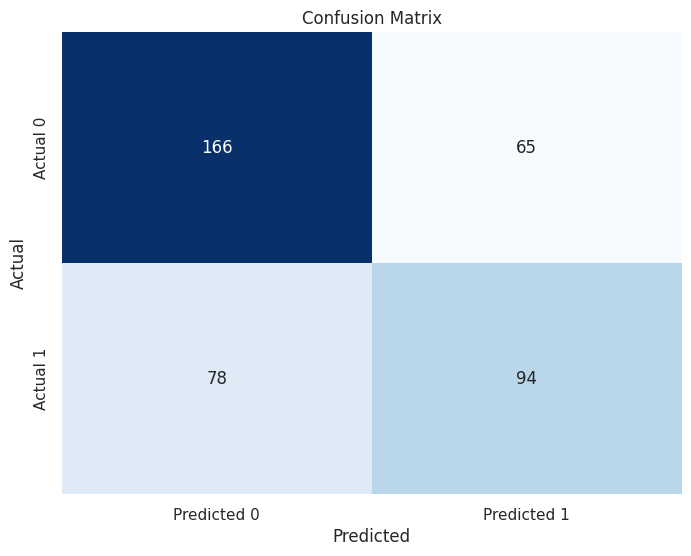

In [66]:
# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Hyperparameters: {rf_params}")
print(f"Accuracy: {accuracy:.4f}")
print("Classification Report:\n", classification_rep)
print("Confusion Matrix:\n", conf_matrix)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted 0', 'Predicted 1'],
            yticklabels=['Actual 0', 'Actual 1'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

Feature Importances:
                Feature  Importance
9            pHxSulfate    0.115329
4               Sulfate    0.111839
0                    ph    0.098470
1              Hardness    0.098331
2                Solids    0.093718
3           Chloramines    0.093472
10  SulfatexChloramines    0.090303
7       Trihalomethanes    0.078730
5          Conductivity    0.074506
6        Organic_carbon    0.073110
8             Turbidity    0.072193


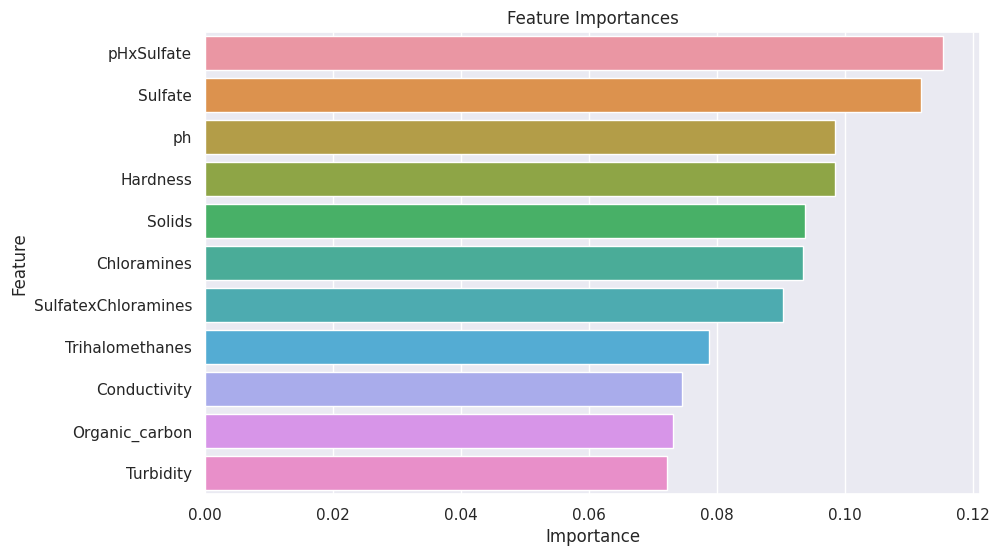

In [67]:
feature_importances = rf_model_best.feature_importances_

# Display feature importances
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances})
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importance_df)

# Plot feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df)
plt.title('Feature Importances')
plt.show()

In [68]:
#filename = "Potability_Model3.pkl"

#Open the file in write-binary mode
#with open(filename, 'wb') as file:
  #pickle.dump(rf_model_best, file)